My name is Matt and I'm an intermediate Python programmer, with a focus on data cleaning and harmonisation - my role is to *harmonise* data across different follow-ups, ensuring that the same questions captured at different time-points have the same variable name, label, and field values, as well as ensuring that different questions (if they're semantically different, or the options to answer the question vary) are named and labelled differently, to ensure consistency across all follow-ups over time.

I have a fairly solid understanding of the basic foundations of programming and data cleaning/analysis. I like using Polars, and have written a simple library `banksia` which is a wrapper around `pyreadstat` to format SPSS files in a way that's more manageable for my workflow. I like to use a more functional style of programming, and prefer concise, simple code. I want to learn about new data structures, algorithms, libraries (standard and third-party) and other tips and tricks that help to improve my processes.

Now that I've selected and confirmed all the appropriate variables, the next step is to investigate the data and metadata, and ensure I can harmonise the G0G1 variables with the previous G227 and G228 variables.

## Set up

In [ ]:
import banksia as bk
import polars as pl
from pathlib import Path
from fastcore.utils import *
import fastcore.all as fc, numpy as np, matplotlib.pyplot as plt
import re, math, itertools, functools, types, typing, dataclasses, collections, regex, time, asyncio
from dialoghelper import *
import ast

In [ ]:
pl.Config.set_fmt_str_lengths(150)  # or whatever length you want

polars.config.Config

In [ ]:
INPUT = Path("../data/input")
OUTPUT = Path("../data/output")

In [ ]:
ch = pl.read_excel("../changes.xlsx")
ch.head()

Could not determine dtype for column 2, falling back to string


Could not determine dtype for column 4, falling back to string


Could not determine dtype for column 6, falling back to string


Could not determine dtype for column 7, falling back to string


file,old_var_name,new_var_name,old_var_label,new_var_label,old_field_values,new_field_values,recode,status
str,str,str,str,str,str,str,str,str
"""G0G1_PA.sav""","""G0G1_AREL""",null,"""Areola Size (Diameter): Right (cm)""",null,"""88=""Not applicable"";99=""Not stated""""",null,null,"""in progress"""
"""G0G1_PA.sav""","""G0G1_ARER""",null,"""Areola Size (Diameter): Left (cm)""",null,"""88=""Not applicable"";99=""Not stated""""",null,null,"""in progress"""
"""G0G1_PA.sav""","""G0G1_BR_COL""",null,"""Breast skin colour""",null,"""1=""Light"";2=""Light/Medium"";3=""Medium"";4=""Medium/Dark"";5=""Dark"";9=""Not stated""""",null,null,"""in progress"""
"""G0G1_PA.sav""","""G0G1_SCAR_LC""",null,"""Breast Scar location: Left Centre""",null,"""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""",null,null,"""in progress"""
"""G0G1_PA.sav""","""G0G1_SCAR_LLIQ""",null,"""Breast Scar location: Left Lower Inner Quadrant""",null,"""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""",null,null,"""in progress"""


In [ ]:
ch = ch.group_by('file').agg(pl.col('old_var_name'))
ch

file,old_var_name
str,list[str]
"""G0G1_PA.sav""","[""G0G1_AREL"", ""G0G1_ARER"", … ""G0G1_PIERR""]"
"""G228_MainQandRQ.sav""","[""G228_AREL"", ""G228_ARER"", … ""G228_PIERR""]"
"""G227_PA.sav""","[""G227_AreL"", ""G227_AreR"", … ""G227_PIERR""]"


For the next step, we'll merge the datasets and metadata together, and begin exploring subsets of these variables

In [ ]:
def merge(vl: pl.DataFrame, dir: str|Path=INPUT) -> tuple[pl.DataFrame, pl.DataFrame]:
    dfs, ms = [], []
    for file, cols in vl.rows():
        df, m = bk.read_sav(dir/file, usecols=["ID"] + cols)
        dfs.append(df), ms.append(m)
    df = pl.concat(dfs, how="align")
    m = pl.concat(ms, how="vertical").filter(pl.col("Variable").ne("ID")).with_columns(basename=pl.col("Variable").str.slice(5))
    return df, m

## TIBS Assessment

### Screenshots of questions from proforma

G227 and G228

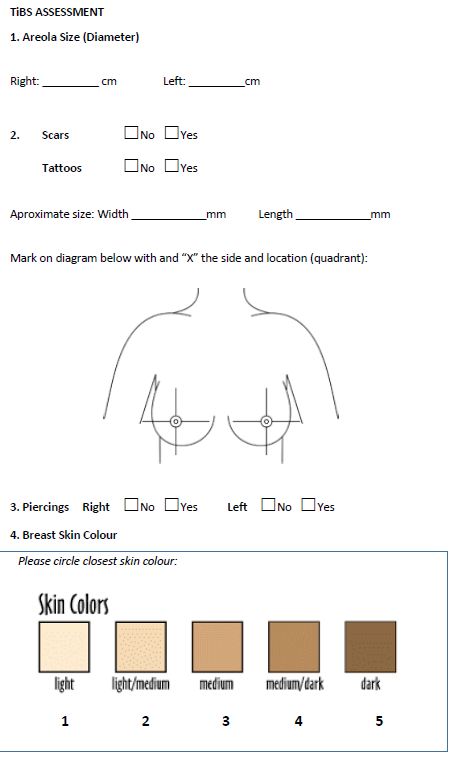
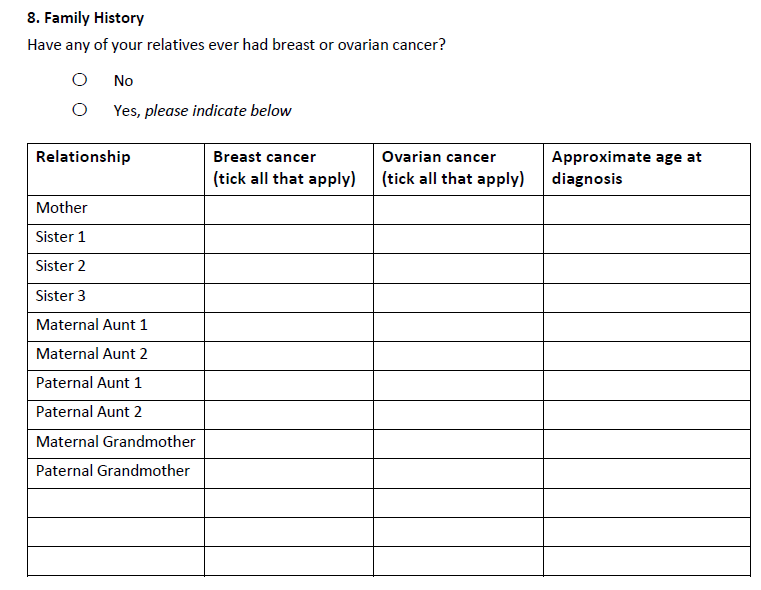
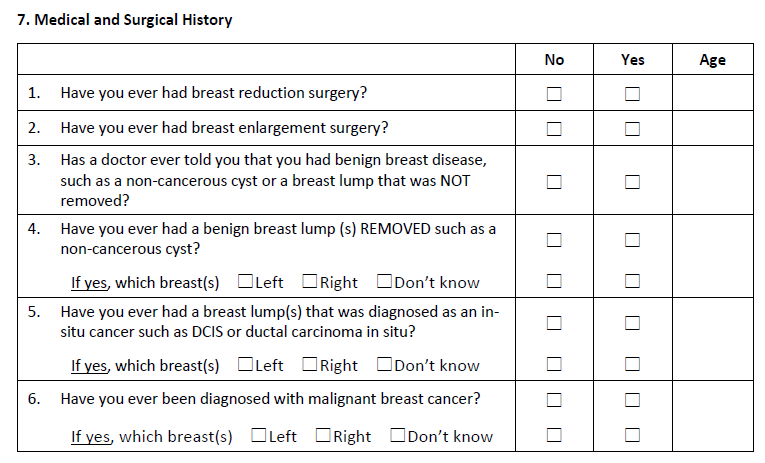

G0G1

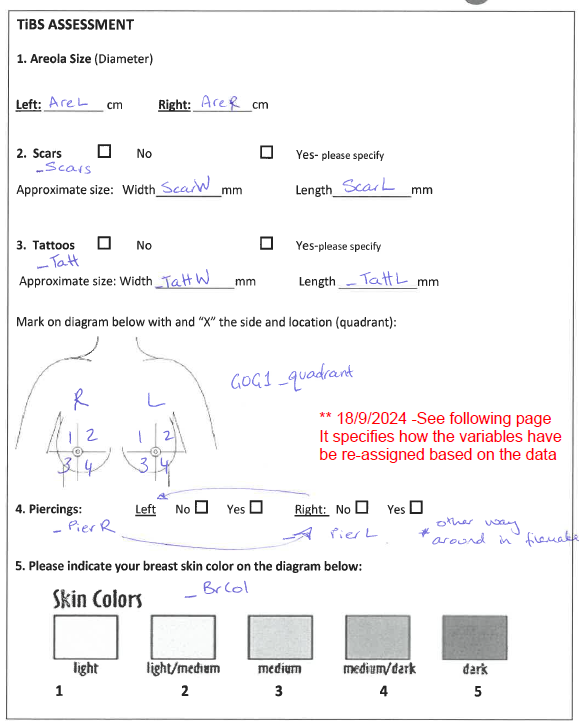
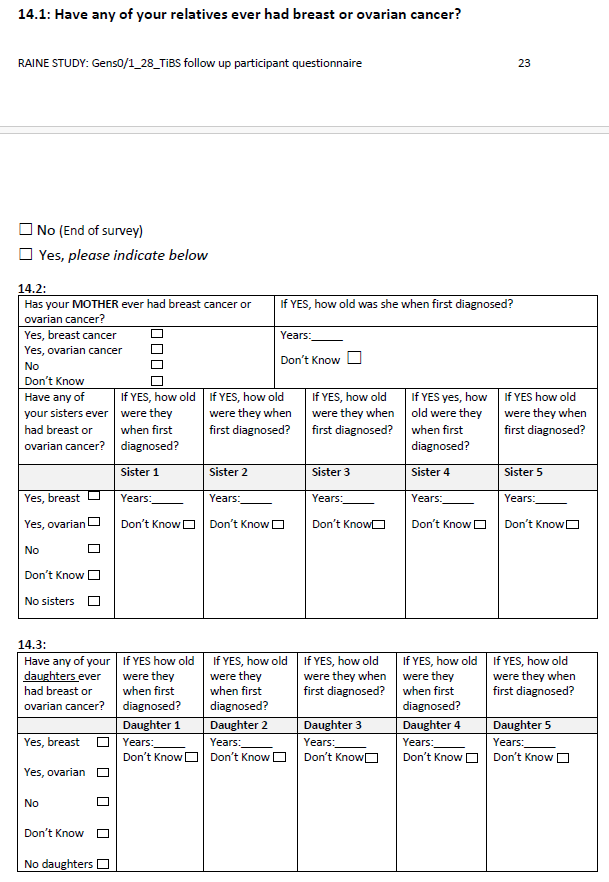
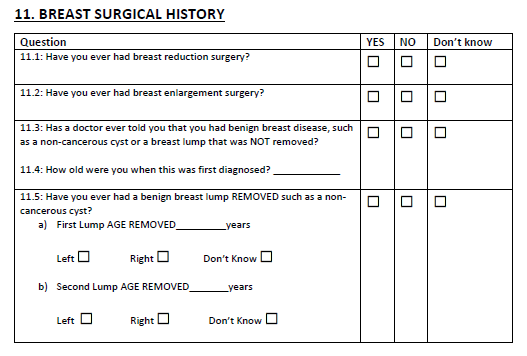
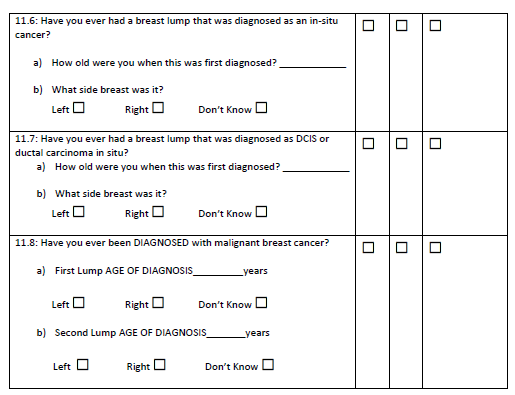
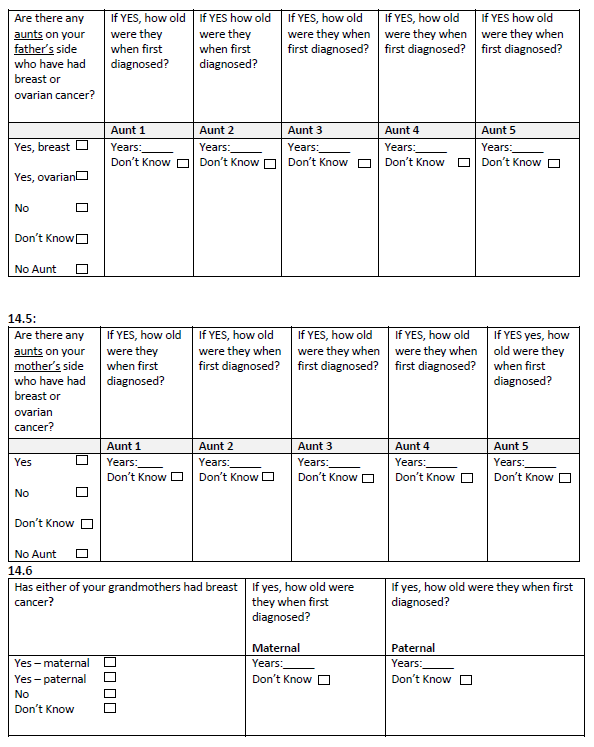

### Investigating the data

In [ ]:
df, m = merge(ch)

In [ ]:
df.head()

ID,G0G1_BR_COL,G0G1_AREL,G0G1_ARER,G0G1_PIER,G0G1_PIERL,G0G1_PIERR,G0G1_SCARS,G0G1_SCARL,G0G1_SCARW,G0G1_SCAR_LC,G0G1_SCAR_LUIQ,G0G1_SCAR_LUOQ,G0G1_SCAR_LLIQ,G0G1_SCAR_LLOQ,G0G1_SCAR_RC,G0G1_SCAR_RUOQ,G0G1_SCAR_RUIQ,G0G1_SCAR_RLOQ,G0G1_SCAR_RLIQ,G0G1_TATT,G0G1_TATTL,G0G1_TATTW,G0G1_TATT_LC,G0G1_TATT_LUIQ,G0G1_TATT_LUOQ,G0G1_TATT_LLIQ,G0G1_TATT_LLOQ,G0G1_TATT_RC,G0G1_TATT_RUOQ,G0G1_TATT_RUIQ,G0G1_TATT_RLOQ,G0G1_TATT_RLIQ,G0G1_TIBS_COM,G228_ARER,G228_AREL,G228_SCARS,…,G228_TATTL,G228_SCAR_RUOQ,G228_SCAR_RUIQ,G228_SCAR_RLIQ,G228_SCAR_RLOQ,G228_SCAR_RC,G228_SCAR_LUIQ,G228_SCAR_LUOQ,G228_SCAR_LLOQ,G228_SCAR_LLIQ,G228_SCAR_LC,G228_TATT_RUOQ,G228_TATT_RUIQ,G228_TATT_RLIQ,G228_TATT_RLOQ,G228_TATT_RC,G228_TATT_LUIQ,G228_TATT_LUOQ,G228_TATT_LLOQ,G228_TATT_LLIQ,G228_TATT_LC,G228_PIER,G228_PIERR,G228_PIERL,G228_BR_COL,G227_AreR,G227_AreL,G227_SCARS,G227_SCARW,G227_SCARL,G227_TATT,G227_TATTW,G227_TATTL,G227_PIERR,G227_PIERL,G227_BR_Col,G227_TiBs_COM
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
301.0,1.0,5.5,5.5,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""No comments""",null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
501.0,2.0,4.0,4.0,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""Could not complete DXA properly because she has an arm injury and difficulty lie down""",null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1201.0,2.0,2.5,2.5,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""No comments""",null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1401.0,3.0,4.0,4.0,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""No comments""",null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1501.0,2.0,4.5,4.8,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""No comments""",null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [ ]:
m.head()

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G0G1_BR_COL""","""Breast skin colour""","""Numeric""",8,0,"""nominal""","""1=""Light"";2=""Light/Medium"";3=""Medium"";4=""Medium/Dark"";5=""Dark"";9=""Not stated""""","""BR_COL"""
"""G0G1_AREL""","""Areola Size (Diameter): Right (cm)""","""Numeric""",8,0,"""scale""","""88=""Not applicable"";99=""Not stated""""","""AREL"""
"""G0G1_ARER""","""Areola Size (Diameter): Left (cm)""","""Numeric""",8,0,"""scale""","""88=""Not applicable"";99=""Not stated""""","""ARER"""
"""G0G1_PIER""","""Any nipple piercings""","""Numeric""",8,0,"""nominal""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""PIER"""
"""G0G1_PIERL""","""Any nipple piercings - Left breast""","""Numeric""",8,0,"""nominal""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""PIERL"""


In [ ]:
def value_counts(df: pl.DataFrame, cols: str | list[str]) -> pl.DataFrame:
    """Get value counts for multiple columns."""
    return df.select(cols).unpivot().group_by(["variable", "value"]).len().pivot(on="variable", index="value", values="len").sort("value").select('value', *cols)

#### Areola Size

In [ ]:
cols = """G0G1_AREL
G0G1_ARER
G227_AreL
G227_AreR
G228_AREL
G228_ARER""".splitlines()

In [ ]:
value_counts(df, cols)

value,G0G1_AREL,G0G1_ARER,G227_AreL,G227_AreR,G228_AREL,G228_ARER
f64,u32,u32,u32,u32,u32,u32
null,2868,2868,2953,2953,3016,3016
1.0,2,2,null,1,null,null
1.1,null,1,null,null,null,null
1.2,null,null,1,null,null,null
1.3,1,null,null,null,null,null
…,…,…,…,…,…,…
10.0,null,null,1,1,1,1
12.0,null,null,1,1,null,null
99.0,19,18,null,null,58,57


In the context of the size of an areola (diameter in cm) how would you make sense of these values?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Looking at the value counts, a few things stand out:

**Plausible measurement range:** Values from ~1.0 to ~8.0 cm look reasonable for areola diameters (typical range is roughly 3-5 cm, but variation exists).

**Edge cases:**
- Values like 10.0 and 12.0 cm are quite large but not impossible
- The 1.0-1.5 cm range is small but plausible

**Missing value codes are inconsistent across follow-ups:**
- G0G1 and G228 use `99` for "Not stated" (and metadata shows `88` for "Not applicable")
- G227 uses `888` and `999` — likely the same meaning but different coding scheme

This is a classic harmonisation issue. Before deciding how to handle it, you might want to check:

1. Does the G227 metadata confirm what 888 and 999 mean?
2. Are there any values between ~12 and 88 that might be real outliers vs. miscoded missing values?

Would you like to filter the metadata to see what G227's field values say for these areola variables?

Spot on. But would "Not applicable" even make sense? Is it plausible for someone not to have areola, especially given it's only one participant?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good catch! "Not applicable" for areola size is unusual but *could* make sense in specific cases — for example, if a participant had a mastectomy or breast reconstruction where the areola was removed or significantly altered.

But you're right to be suspicious when it's just one participant. It could be:
1. A legitimate clinical case
2. A data entry error (e.g., meant to enter 99 for "not stated" but typed 888)
3. A one-off coding decision by whoever entered the data

Since it's only one person, it might be worth checking if that same participant has other indicators (e.g., notes in a comments field, or unusual values in related breast variables) that would explain it.

Would you like to look at that specific row to see what else is going on with that participant?

In [ ]:
# Let's check the data
df.filter(pl.col('G227_AreL').eq(888)).item(0, -1)

'Had a breast reduction on the right side\nHad a breast implant on the left side\n\nAll scars were on the right side located under the breast.\n\nScan was only run on the right side'

In [ ]:
import polars.selectors as cs
df.filter(pl.col('G227_AreL').eq(888)).select(cs.matches(r'(?i).*are.*$'))

G0G1_AREL,G0G1_ARER,G228_ARER,G228_AREL,G227_AreR,G227_AreL
f64,f64,f64,f64,f64,f64
null,null,99.0,99.0,2.5,888.0


Fair enough, this is a reasonable use of "N/A". For this *one* case, I suppose we better keep it!  
However, we still need to harmonise the values, and rename this variable with all caps to match the others.

#### Scars

In [ ]:
cols = """G0G1_SCARL
G0G1_SCARS
G0G1_SCARW
G227_SCARL
G227_SCARS
G227_SCARW
G228_SCARL
G228_SCARS
G228_SCARW""".splitlines()

In [ ]:
value_counts(df, cols)

value,G0G1_SCARL,G0G1_SCARS,G0G1_SCARW,G227_SCARL,G227_SCARS,G227_SCARW,G228_SCARL,G228_SCARS,G228_SCARW
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2956,2953,2958,3016,3016,3016
-99.0,19,11,25,2,2,2,46,41,41
-88.0,556,null,556,487,null,487,370,null,370
0.0,1,556,1,null,487,null,null,370,null
1.0,null,17,2,null,10,null,null,25,11
…,…,…,…,…,…,…,…,…,…
30.0,null,null,null,1,null,null,4,null,null
40.0,1,null,null,null,null,null,null,null,null
50.0,1,null,null,1,null,null,1,null,null


#### Scar Locations

In [ ]:
cols = """G0G1_SCAR_LC
G0G1_SCAR_LLIQ
G0G1_SCAR_LLOQ
G0G1_SCAR_LUIQ
G0G1_SCAR_LUOQ
G0G1_SCAR_RC
G0G1_SCAR_RLIQ
G0G1_SCAR_RLOQ
G0G1_SCAR_RUIQ
G0G1_SCAR_RUOQ
G228_SCAR_LC
G228_SCAR_LLIQ
G228_SCAR_LLOQ
G228_SCAR_LUIQ
G228_SCAR_LUOQ
G228_SCAR_RC
G228_SCAR_RLIQ
G228_SCAR_RLOQ
G228_SCAR_RUIQ
G228_SCAR_RUOQ""".splitlines()

In [ ]:
value_counts(df, cols)

value,G0G1_SCAR_LC,G0G1_SCAR_LLIQ,G0G1_SCAR_LLOQ,G0G1_SCAR_LUIQ,G0G1_SCAR_LUOQ,G0G1_SCAR_RC,G0G1_SCAR_RLIQ,G0G1_SCAR_RLOQ,G0G1_SCAR_RUIQ,G0G1_SCAR_RUOQ,G228_SCAR_LC,G228_SCAR_LLIQ,G228_SCAR_LLOQ,G228_SCAR_LUIQ,G228_SCAR_LUOQ,G228_SCAR_RC,G228_SCAR_RLIQ,G228_SCAR_RLOQ,G228_SCAR_RUIQ,G228_SCAR_RUOQ
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2868,2868,2868,2868,2868,2868,2868,3016,3016,3016,3016,3016,3016,3016,3016,3016,3016
-99.0,21,21,21,21,21,21,21,21,21,21,41,41,41,41,41,41,41,41,41,41
-88.0,556,556,556,556,556,556,556,556,556,556,370,370,370,370,370,370,370,370,370,370
0.0,6,6,6,4,6,6,6,6,6,5,23,23,22,24,23,20,21,21,24,20
1.0,1,1,1,3,1,1,1,1,1,2,2,2,3,1,2,5,4,4,1,5


In [ ]:
df.filter(pl.col('ID').eq(213901)).select(r'^G0G1_SCAR.*$')

G0G1_SCARS,G0G1_SCARL,G0G1_SCARW,G0G1_SCAR_LC,G0G1_SCAR_LUIQ,G0G1_SCAR_LUOQ,G0G1_SCAR_LLIQ,G0G1_SCAR_LLOQ,G0G1_SCAR_RC,G0G1_SCAR_RUOQ,G0G1_SCAR_RUIQ,G0G1_SCAR_RLOQ,G0G1_SCAR_RLIQ
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This was the only ID with scarring I could find in the archives.  
Though it didn't mark an "X" on any quadrant/s, there was a comment noting "left side", which is evidence that the current coding is correct.

In [ ]:
df.filter(pl.col('ID').is_in([23870, 40040])).select(r'^G228_SCAR.*$')

G228_SCARS,G228_SCARW,G228_SCARL,G228_SCAR_RUOQ,G228_SCAR_RUIQ,G228_SCAR_RLIQ,G228_SCAR_RLOQ,G228_SCAR_RC,G228_SCAR_LUIQ,G228_SCAR_LUOQ,G228_SCAR_LLOQ,G228_SCAR_LLIQ,G228_SCAR_LC
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,60.0,60.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1.0,1.0,-99.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Annoyingly, the only two IDs I could find to confirm had scars on mirroring sides (both centre or outer quadrant) so I cannot confirm.

#### Tattoos

In [ ]:
cols = """G0G1_TATT
G0G1_TATTL
G0G1_TATTW
G227_TATT
G227_TATTL
G227_TATTW
G228_TATT
G228_TATTL
G228_TATTW""".splitlines()

In [ ]:
value_counts(df, cols)

value,G0G1_TATT,G0G1_TATTL,G0G1_TATTW,G227_TATT,G227_TATTL,G227_TATTW,G228_TATT,G228_TATTL,G228_TATTW
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2952,2952,2952,3016,3016,3016
-99.0,13,13,13,1,1,1,36,37,38
-88.0,null,566,566,null,496,496,null,396,396
0.0,566,null,null,496,null,null,396,null,null
1.0,5,null,null,3,null,null,4,null,null
…,…,…,…,…,…,…,…,…,…
50.0,null,1,1,null,null,null,null,null,null
60.0,null,1,1,null,1,1,null,null,null
70.0,null,null,null,null,1,null,null,null,null


#### Tattoo Locations

In [ ]:
cols = """G0G1_TATT_LC
G0G1_TATT_LLIQ
G0G1_TATT_LLOQ
G0G1_TATT_LUIQ
G0G1_TATT_LUOQ
G0G1_TATT_RC
G0G1_TATT_RLIQ
G0G1_TATT_RLOQ
G0G1_TATT_RUIQ
G0G1_TATT_RUOQ
G228_TATT_LC
G228_TATT_LLIQ
G228_TATT_LLOQ
G228_TATT_LUIQ
G228_TATT_LUOQ
G228_TATT_RC
G228_TATT_RLIQ
G228_TATT_RLOQ
G228_TATT_RUIQ
G228_TATT_RUOQ""".splitlines()

In [ ]:
value_counts(df, cols)

value,G0G1_TATT_LC,G0G1_TATT_LLIQ,G0G1_TATT_LLOQ,G0G1_TATT_LUIQ,G0G1_TATT_LUOQ,G0G1_TATT_RC,G0G1_TATT_RLIQ,G0G1_TATT_RLOQ,G0G1_TATT_RUIQ,G0G1_TATT_RUOQ,G228_TATT_LC,G228_TATT_LLIQ,G228_TATT_LLOQ,G228_TATT_LUIQ,G228_TATT_LUOQ,G228_TATT_RC,G228_TATT_RLIQ,G228_TATT_RLOQ,G228_TATT_RUIQ,G228_TATT_RUOQ
f64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2868,2868,2868,2868,2868,2868,2868,3016,3016,3016,3016,3016,3016,3016,3016,3016,3016
-99.0,16,16,16,16,16,16,16,16,16,16,36,36,36,36,36,36,36,36,36,36
-88.0,566,566,566,566,566,566,566,566,566,566,396,396,396,396,396,396,396,396,396,396
0.0,2,2,2,1,1,2,2,2,2,2,4,4,4,4,4,4,4,4,4,3
1.0,null,null,null,1,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1


In [ ]:
df.filter(pl.col('G228_TATT').eq(1))['ID']

ID
f64
10360.0
10660.0
16790.0
41180.0


Unfortunately, we don't possess any of the G228 IDs, and so again can't confirm/verify the data.

In [ ]:
df.filter(pl.col('G0G1_TATT').eq(1))['ID']

ID
f64
16301.0
99701.0
127901.0
210801.0
226901.0


In [ ]:
df.filter(pl.col('ID').is_in([210801, 226901])).select(r'^G0G1_TATT.*$')

G0G1_TATT,G0G1_TATTL,G0G1_TATTW,G0G1_TATT_LC,G0G1_TATT_LUIQ,G0G1_TATT_LUOQ,G0G1_TATT_LLIQ,G0G1_TATT_LLOQ,G0G1_TATT_RC,G0G1_TATT_RUOQ,G0G1_TATT_RUIQ,G0G1_TATT_RLOQ,G0G1_TATT_RLIQ
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,50.0,50.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1.0,30.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Frustratingly, for `210801`, there's valid data, and a clear "X" on the upper-inner right quadrant, but all the data is labelled "Missing".  
At least for `226901` there's an "X" on the upper-outer left quadrant, as per the data, which is again evidence it's been correctly coded.

#### Piercings

Remind me - what have we completed thus far, and which variables are we still a bit suspect on?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Here's a summary:

**Completed investigations:**

| Variable Group | Status | Notes |
|----------------|--------|-------|
| **Areola Size** | ✓ Mostly resolved | Need to harmonise missing codes (99 vs 888/999) and rename G227 vars to uppercase. One legitimate N/A (888) for breast reduction/implant case. |
| **Scars (Y/N, W, L)** | ✓ Reviewed | Consistent coding across follow-ups (-99=Missing, -88=N/A, 0=No, 1=Yes) |
| **Scar Locations** | ⚠️ Reviewed but uncertain | G227 doesn't have location vars. Couldn't verify L/R assignment — only found mirroring cases. |
| **Tattoos (Y/N, W, L)** | ✓ Reviewed | Similar structure to scars |
| **Tattoo Locations** | ⚠️ One suspect case | ID 210801 has valid measurements but all locations coded -99 despite clear X on proforma. ID 226901 confirmed correct. |

**Still to investigate:**
- Piercings (PIER, PIERL, PIERR)
- Breast Skin Colour (BR_COL)

**Main outstanding concerns:**
1. Can't definitively confirm the L/R quadrant assignment for scars (no asymmetric cases to verify)
2. ID 210801 appears to have a data entry error for tattoo locations

Shall we move on to Piercings?

In [ ]:
cols = """G0G1_PIER
G0G1_PIERL
G0G1_PIERR
G227_PIERL
G227_PIERR
G228_PIER
G228_PIERL
G228_PIERR""".splitlines()

In [ ]:
value_counts(df, cols)

value,G0G1_PIER,G0G1_PIERL,G0G1_PIERR,G227_PIERL,G227_PIERR,G228_PIER,G228_PIERL,G228_PIERR
f64,u32,u32,u32,u32,u32,u32,u32,u32
null,2868,2868,2868,2951,2951,3016,3016,3016
-99.0,10,10,10,35,3,37,39,37
-88.0,null,572,572,null,null,null,376,376
0.0,572,null,null,454,482,376,6,5
1.0,2,2,2,12,16,23,15,18


#### Breast Colour

In [ ]:
cols = """G0G1_BR_COL
G227_BR_Col
G228_BR_COL""".splitlines()

In [ ]:
value_counts(df, cols)

value,G0G1_BR_COL,G227_BR_Col,G228_BR_COL
f64,u32,u32,u32
null,2868,2951,3016
1.0,332,229,203
2.0,216,234,168
3.0,17,28,23
4.0,3,7,5
5.0,null,1,null
9.0,16,null,37
99.0,null,2,null


#### TIBS Comments

In [ ]:
assert df.filter(pl.col("G227_TiBs_COM").str.contains(r"[^\x20-\x7E]")).height == 0

AssertionError: 

In [ ]:
assert df.filter(pl.col("G0G1_TIBS_COM").str.contains(r"[^\x20-\x7E]")).height == 0

AssertionError: 

In [ ]:
df.filter(pl.col("G227_TiBs_COM").str.contains(r"[^\x20-\x7E]"))["G227_TiBs_COM"].to_list()

['\nHad second measurement done 29/8/17\nNot pregnant any more and LMP: 23/8/17\nAreola diameter : R - 4.5cm L - 4cm',
 'nipple size - 2.5\nM grandmother age of diagnosis 70 - add',
 'Q6. "also has PCOS - diagnosed at 15 and has been on OC pill ever since. So unsure of cycle now - sometimes 28 days/sometimes months. Doesn\'t know is the real answer"\n\nQ7. " Had us at 25 - was told has very lumpy breasts but nothing wrong"\n\nQ8. Paternal Grandmother - breast cancer. "Possibly - couldn\'t stage \'primary\' cancer - had spread all over (63)"',
 'Scar from augmentation, no TiBs due to implants\n\nMaternal cousin had breast cancer: Approximate age at diagnosis = 45yrs',
 '1st Ref & left breast - 1st file\n2nd Right breast & 2nd ref- 2nd file',
 'No TiBs due to implants\nFamily history: 1st Cousin, Breast Cancer, Age 37. (No option on list for cousins)',
 "Maternal aunt had cervical cancer (late 40s)\nMum's cousin had breast cancer (50+ years)\nMum's cousin had either breast cancer or ovar

It appears that new-line characters (`\n`) are causing the problem.
Let's replace them with a semi-colon and see if there are further issues.

In [ ]:
dfx = df.with_columns(
    pl.col("G227_TiBs_COM").str.replace_all(r'(\n)+', '; '),
    pl.col("G0G1_TIBS_COM").str.replace_all(r'(\n)+', '; '))

In [ ]:
assert dfx.filter(pl.col("G227_TiBs_COM").str.contains(r"[^\x20-\x7E]")).height == 0
assert dfx.filter(pl.col("G0G1_TIBS_COM").str.contains(r"[^\x20-\x7E]")).height == 0

### Overview of changes to implement

#### Explore `changes`

In [ ]:
changes = pl.read_excel("../changes.xlsx")
changes.head()

file,old_var_name,new_var_name,old_var_label,new_var_label,old_field_values,new_field_values,recode,status
str,str,str,str,str,str,str,str,str
"""G0G1_PA.sav""","""G0G1_AREL""",null,"""Areola Size (Diameter): Right (cm)""","""Areola size (cm) - left""","""88=""Not applicable"";99=""Not stated""""","""-99=""Missing"";-88=""N/A""""","""{99: -99}""","""complete"""
"""G0G1_PA.sav""","""G0G1_ARER""",null,"""Areola Size (Diameter): Left (cm)""","""Areola size (cm) - right""","""88=""Not applicable"";99=""Not stated""""","""-99=""Missing"";-88=""N/A""""","""{99: -99}""","""complete"""
"""G0G1_PA.sav""","""G0G1_BR_COL""",null,"""Breast skin colour""",null,"""1=""Light"";2=""Light/Medium"";3=""Medium"";4=""Medium/Dark"";5=""Dark"";9=""Not stated""""","""-99=""Missing"";1=""Light"";2=""Light/medium"";3=""Medium"";4=""Medium/dark"";5=""Dark""""","""{9: -99}""","""complete"""
"""G0G1_PA.sav""","""G0G1_SCAR_LC""",null,"""Breast Scar location: Left Centre""",null,"""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""",null,null,"""complete"""
"""G0G1_PA.sav""","""G0G1_SCAR_LLIQ""",null,"""Breast Scar location: Left Lower Inner Quadrant""",null,"""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""",null,null,"""complete"""


Let's filter for variables that need to be updated in some way, whether it's renaming the variable name, updating the label/field values, or recoding values.

In [ ]:
filtered_changes = changes.filter(pl.col("new_var_name").is_not_null() | pl.col("new_var_label").is_not_null() | pl.col("new_field_values").is_not_null() | pl.col("recode").is_not_null())
filtered_changes.head()

file,old_var_name,new_var_name,old_var_label,new_var_label,old_field_values,new_field_values,recode,status
str,str,str,str,str,str,str,str,str
"""G0G1_PA.sav""","""G0G1_AREL""",null,"""Areola Size (Diameter): Right (cm)""","""Areola size (cm) - left""","""88=""Not applicable"";99=""Not stated""""","""-99=""Missing"";-88=""N/A""""","""{99: -99}""","""complete"""
"""G0G1_PA.sav""","""G0G1_ARER""",null,"""Areola Size (Diameter): Left (cm)""","""Areola size (cm) - right""","""88=""Not applicable"";99=""Not stated""""","""-99=""Missing"";-88=""N/A""""","""{99: -99}""","""complete"""
"""G0G1_PA.sav""","""G0G1_BR_COL""",null,"""Breast skin colour""",null,"""1=""Light"";2=""Light/Medium"";3=""Medium"";4=""Medium/Dark"";5=""Dark"";9=""Not stated""""","""-99=""Missing"";1=""Light"";2=""Light/medium"";3=""Medium"";4=""Medium/dark"";5=""Dark""""","""{9: -99}""","""complete"""
"""G227_PA.sav""","""G227_AreL""","""G227_AREL""","""Areola size (cm) - left""",null,"""888=""NA"";999=""missing""""","""-99=""Missing"";-88=""N/A""""","""{888: -88, 999: -99}""","""complete"""
"""G227_PA.sav""","""G227_AreR""","""G227_ARER""","""Areola size (cm) - right""",null,"""888=""NA"";999=""missing""""","""-99=""Missing"";-88=""N/A""""","""{888: -88, 999: -99}""","""complete"""


From this table, we want to identify the changes to make, both for the data and metadata, and subsequently create functions to apply the necessary transformations.

For the changes in data, we'll want to know the file, old_var_name, new_var_name, and the values to recode.  
For changes in metadata, we want to know the file, old_var_name, new_var_name, and then the final var_label and field_values, which will entail taking the new values if they exist, or else referring to the old values.

#### Changes in data

In [ ]:
#| export
def get_data_transforms(changes: pl.DataFrame, file: str) -> tuple[dict, list]:
    "Build rename dict and recode expressions from the changes specified in the spreadsheet."
    fc = changes.filter(pl.col('file').eq(file))
    r = fc.filter(pl.col('new_var_name').is_not_null())
    renames = dict(zip(r['old_var_name'], r['new_var_name']))
    rc = fc.group_by('recode').agg(pl.col('old_var_name')).filter(pl.col('recode').is_not_null())
    exprs = [pl.col(row['old_var_name']).replace(ast.literal_eval(row['recode'])) 
             for row in rc.iter_rows(named=True)]
    return renames, exprs

In [ ]:
renames, exprs = get_data_transforms(changes, 'G0G1_Q.sav')
df_transformed = df.with_columns(*exprs).rename(renames)
df_transformed.select("^G0G1.*$").head()

G0G1_BR_COL,G0G1_AREL,G0G1_ARER,G0G1_PIER,G0G1_PIERL,G0G1_PIERR,G0G1_SCARS,G0G1_SCARL,G0G1_SCARW,G0G1_SCAR_LC,G0G1_SCAR_LUIQ,G0G1_SCAR_LUOQ,G0G1_SCAR_LLIQ,G0G1_SCAR_LLOQ,G0G1_SCAR_RC,G0G1_SCAR_RUOQ,G0G1_SCAR_RUIQ,G0G1_SCAR_RLOQ,G0G1_SCAR_RLIQ,G0G1_TATT,G0G1_TATTL,G0G1_TATTW,G0G1_TATT_LC,G0G1_TATT_LUIQ,G0G1_TATT_LUOQ,G0G1_TATT_LLIQ,G0G1_TATT_LLOQ,G0G1_TATT_RC,G0G1_TATT_RUOQ,G0G1_TATT_RUIQ,G0G1_TATT_RLOQ,G0G1_TATT_RLIQ,G0G1_TIBS_COM
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
1.0,5.5,5.5,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""No comments"""
2.0,4.0,4.0,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""Could not complete DXA properly because she has an arm injury and difficulty lie down"""
2.0,2.5,2.5,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""No comments"""
3.0,4.0,4.0,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""No comments"""
2.0,4.5,4.8,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""No comments"""


In [ ]:
#| export
def harmonise_data(df: pl.DataFrame, changes: pl.DataFrame, file: str) -> pl.DataFrame:
    renames, exprs = get_data_transforms(changes, file)
    return df.with_columns(*exprs).rename(renames)

Great! That seems to work well. Let's move on to writing a function that creates expression to update the metadata from the changes dataframe.

#### Updating the metadata

In [ ]:
#| export
def harmonise_metadata(m: pl.DataFrame, changes: pl.DataFrame) -> pl.DataFrame:
    """Apply variable name, label, and field value changes to metadata."""
    return m.join(changes, left_on="Variable", right_on="old_var_name", how="left").with_columns(
        pl.coalesce("new_var_name", "Variable").alias("Variable"),
        pl.coalesce("new_var_label", "Label").alias("Label"),
        pl.coalesce("new_field_values", "Field Values").alias("Field Values"),
    ).select(m.columns)

In [ ]:
harmonise_metadata(m, changes).filter(pl.col("Variable").str.starts_with("G0G1"))

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values,basename
str,str,str,i64,i64,str,str,str
"""G0G1_BR_COL""","""Breast skin colour""","""Numeric""",8,0,"""nominal""","""-99=""Missing"";1=""Light"";2=""Light/medium"";3=""Medium"";4=""Medium/dark"";5=""Dark""""","""BR_COL"""
"""G0G1_AREL""","""Areola size (cm) - left""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""AREL"""
"""G0G1_ARER""","""Areola size (cm) - right""","""Numeric""",8,0,"""scale""","""-99=""Missing"";-88=""N/A""""","""ARER"""
"""G0G1_PIER""","""Any nipple piercings""","""Numeric""",8,0,"""nominal""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""PIER"""
"""G0G1_PIERL""","""Any nipple piercings - Left breast""","""Numeric""",8,0,"""nominal""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""PIERL"""
…,…,…,…,…,…,…,…
"""G0G1_TATT_RUOQ""","""Breast Tattoo location: Right Upper Outer Quadrant""","""Numeric""",8,0,"""nominal""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""TATT_RUOQ"""
"""G0G1_TATT_RUIQ""","""Breast Tattoo location: Right Upper Inner Quadrant""","""Numeric""",8,0,"""nominal""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""TATT_RUIQ"""
"""G0G1_TATT_RLOQ""","""Breast Tattoo location: Right Lower Outer Quadrant""","""Numeric""",8,0,"""nominal""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes""""","""TATT_RLOQ"""


Looking good!

## Finalise changes

In [ ]:
df, m = bk.read_sav(INPUT/"G0G1_PA.sav")

In [ ]:
dfx = harmonise_data(df, changes, "G0G1_PA.sav")
mx = harmonise_metadata(m, changes)

In [ ]:
# Additional harmonisation - replace non-ascii characters (new-lines) with semi-colons
dfx = dfx.with_columns(pl.col("G0G1_TIBS_COM").str.replace_all(r'(\n)+', '; '))

In [ ]:
dfx.head()

ID,G0G1_PA_DATE,G0G1_Q_OP,G0G1_Q_DONE,G0G1_TIBS_DONE,G0G1_HEIGHT_DONE,G0G1_WEIGHT_DONE,G0G1_WAIST_HIP_DONE,G0G1_BREXA,G0G1_BREXA_REASON,G0G1_DEXA,G0G1_DEXA_REASON,G0G1_PS_MED_COND,G0G1_BLOOD_DONE,G0G1_CON_PA,G0G1_CON_Q,G0G1_CON_TIBS,G0G1_CON_BREXA,G0G1_CON_DEXA,G0G1_CON_BLD,G0G1_CON_BLD_DNA,G0G1_CON_DNA_STORED,G0G1_CON_DATALINK,G0G1_CON_DATALINK_MED,G0G1_CON_FUT_RES,G0G1_CON_MAM,G0G1_WEIGHT,G0G1_HEIGHT,G0G1_A12,G0G1_A13,G0G1_BMI,G0G1_AN_RA,G0G1_BP_RA,G0G1_BP_DONE,G0G1_BP_TIME,G0G1_BP_CUFF,G0G1_BP46,…,G0G1_MAM_POSTCODE,G0G1_MAM_SUBURB,G0G1_MAM_YR,G0G1_BR_COL,G0G1_AREL,G0G1_ARER,G0G1_PIER,G0G1_PIERL,G0G1_PIERR,G0G1_SCARS,G0G1_SCARL,G0G1_SCARW,G0G1_SCAR_LC,G0G1_SCAR_LUIQ,G0G1_SCAR_LUOQ,G0G1_SCAR_LLIQ,G0G1_SCAR_LLOQ,G0G1_SCAR_RC,G0G1_SCAR_RUOQ,G0G1_SCAR_RUIQ,G0G1_SCAR_RLOQ,G0G1_SCAR_RLIQ,G0G1_TATT,G0G1_TATTL,G0G1_TATTW,G0G1_TATT_LC,G0G1_TATT_LUIQ,G0G1_TATT_LUOQ,G0G1_TATT_LLIQ,G0G1_TATT_LLOQ,G0G1_TATT_RC,G0G1_TATT_RUOQ,G0G1_TATT_RUIQ,G0G1_TATT_RLOQ,G0G1_TATT_RLIQ,G0G1_TIBS_COM,G0G1_ASS_COM
f64,date,f64,f64,f64,f64,f64,f64,f64,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,time,f64,f64,…,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
301.0,2019-07-19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"""Not applicable - complete""",0.0,"""Not applicable- not done""",1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,112.7,157.5,94.5,128.5,45.43,"""DP""","""SG""",1.0,null,3.0,183.0,…,6107.0,"""CANNINGTON""",2019.0,1.0,5.5,5.5,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""No comments""","""WBD 19/07/2019"""
501.0,2019-03-29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"""Not applicable - complete""",0.0,"""Not applicable- not done""",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,95.8,162.2,100.5,112.5,36.41,"""DP""","""DP""",1.0,11:30:00,3.0,114.0,…,6065.0,"""WANNEROO""",2018.0,2.0,4.0,4.0,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""Could not complete DXA properly because she has an arm injury and difficulty lie down""","""WBD 29/03/2019"""
1201.0,2019-07-19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,"""Not applicable - complete""",0.0,"""Not applicable- not done""",1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,53.5,156.9,66.75,76.5,21.73,"""DP""","""DP""",1.0,null,2.0,125.0,…,6000.0,"""PERTH""",2019.0,2.0,2.5,2.5,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""No comments""","""WBD 19/07/2019"""
1401.0,2018-10-10,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"""No Mammogram data""",0.0,"""Not applicable- not done""",1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,62.9,162.0,85.45,89.0,23.97,"""DP""","""DP""",1.0,09:50:00,2.0,187.0,…,8888.0,"""NA - NOT DONE""",8888.0,3.0,4.0,4.0,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""No comments""","""Never had a mammogram, no BREXA"""
1501.0,2019-02-21,1.0,1.0,1.0,1.0,1.0,1.0,0.0,"""Not stated""",0.0,"""Not applicable- not done""",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,102.6,165.5,103.0,116.0,37.46,"""MP""","""MP""",1.0,null,2.0,103.0,…,6107.0,"""CANNINGTON""",2018.0,2.0,4.5,4.8,0.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,0.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,"""No comments""","""No Comments"""


In [ ]:
mx.head()

Variable,Label,Field Type,Field Width,Decimals,Variable Type,Field Values
str,str,str,i64,i64,str,str
"""ID""","""None""","""Numeric""",8,2,"""scale""",null
"""G0G1_PA_DATE""","""G0G1_PA_date""","""Date""",14,0,"""scale""",null
"""G0G1_Q_OP""","""Questionnaire online or paper""","""Numeric""",8,0,"""nominal""","""1=""Online"";2=""Paper"";9=""Not stated"""""
"""G0G1_Q_DONE""","""Participant questionnaire completed""","""Numeric""",8,0,"""nominal""","""0=""No"";1=""Yes"";8=""Not applicable"";9=""Not stated"""""
"""G0G1_TIBS_DONE""","""TiBs measured""","""Numeric""",8,0,"""nominal""","""-99=""Missing"";-88=""N/A"";0=""No"";1=""Yes"""""


First, let's run a few tests to ensure our changes have been correctly implemented, and we haven't introduced any unwanted changes.

In [ ]:
#| export
def test_unchanged_columns(old_df: pl.DataFrame, new_df: pl.DataFrame, changes: pl.DataFrame) -> bool:
    "Verify columns not recoded/renamed are identical between old and new dataframes."
    fc = changes.filter(pl.col("new_var_name").is_not_null() | pl.col("new_var_label").is_not_null() | pl.col("new_field_values").is_not_null() | pl.col("recode").is_not_null())
    unchanged_cols = [c for c in old_df.columns if c not in fc['old_var_name']]
    for col in unchanged_cols:
        if not old_df[col].equals(new_df[col]):
            print(f"Mismatch in column: {col}")
            return False
    print(f"All {len(unchanged_cols)} unchanged columns are identical.")
    return True

In [ ]:
assert test_unchanged_columns(df, dfx, changes)

Mismatch in column: G0G1_TIBS_COM


AssertionError: 

In [ ]:
#| export
def test_recoding(old_df, new_df, changes, file):
    fc = changes.filter(pl.col('file').eq(file) & pl.col('recode').is_not_null())
    for row in fc.iter_rows(named=True):
        old_col = row.get('old_var_name')
        new_col = row.get('new_var_name') or old_col
        mapping = ast.literal_eval(row['recode'])
        for old_val, new_val in mapping.items():
            old_count = old_df.filter(pl.col(old_col).is_in([old_val, new_val])).height
            new_count = new_df.filter(pl.col(new_col) == new_val).height
            assert old_count == new_count

In [ ]:
test_recoding(df, dfx, changes, 'G0G1_PA.sav')

In [ ]:
bk.write_sav(OUTPUT/"G0G1_PA.sav", dfx, mx)

Let's compose this into a single function that runs across all files with specified changes

In [ ]:
#| export
def harmonise(changes: pl.DataFrame):
    "Complete the harmonisation project, writing all changes specified in the `changes.xlsx` file to the respective SPSS files in `data/input`"
    fc = changes.filter(pl.col("new_var_name").is_not_null() | pl.col("new_var_label").is_not_null() | pl.col("new_field_values").is_not_null() | pl.col("recode").is_not_null())
    for f in fc['file'].unique().to_list():
        df, m = bk.read_sav(INPUT/f)
        renames, exprs = get_data_transforms(fc, f)
        dfx = harmonise_data(df, fc, f)
        mx = harmonise_metadata(m, fc)
        assert test_unchanged_columns(df, dfx, renames)
        bk.write_sav(OUTPUT/f, dfx, mx)

In [ ]:
filtered_changes.filter(pl.col('file').str.starts_with('G227'))

In [ ]:
#| export
def summarise_changes(fc: pl.DataFrame) -> str:
    """Generate markdown summary of harmonised and renamed variables per file."""
    lines = []
    for f in fc['file'].unique().sort().to_list():
        file_changes = fc.filter(pl.col('file').eq(f))
        lines.append(f"## {f}")
        
        # Harmonised (no rename)
        harmonised = file_changes.filter(pl.col('new_var_name').is_null())['old_var_name'].to_list()
        if harmonised:
            lines.append("### Harmonised")
            lines.append(", ".join(harmonised))
        
        # Renamed
        renamed = file_changes.filter(pl.col('new_var_name').is_not_null())
        if renamed.height > 0:
            lines.append("### Renamed")
            pairs = [f"{old} -> {new}" for old, new in zip(renamed['old_var_name'], renamed['new_var_name'])]
            lines.append(", ".join(pairs))
        
        lines.append("")  # blank line between files
    
    return "\n".join(lines)

In [ ]:
print(summarise_changes(filtered_changes))

See Work folder Data Officer - Matt\1 Data Harmonisation20251211 Breast and Ovarian Cancer Family History